In [16]:
import json

LOG_DIR = "benchmark_logs"
LOG_DIR = "better_benchmarks"

LOG_PATH = f"{LOG_DIR}/phi4-before-system-prompt.jsonl"
LOG_PATH = f"{LOG_DIR}/deepseek-r1-14b_20250716-154120.jsonl"
LOG_PATH = f"{LOG_DIR}/sqlcoder-latest_20250716-160249.jsonl"
LOG_PATH = f"{LOG_DIR}/qwen2.5-coder-14b_20250716-162700.jsonl"
LOG_PATH = f"{LOG_DIR}/gemma3-12b_20250716-165749.jsonl"
LOG_PATH = f"{LOG_DIR}/gpt-4.1_20250716-175823.jsonl"
LOG_PATH = f"{LOG_DIR}/gpt-4.1-nano_20250716-173648.jsonl"
LOG_PATH = f"{LOG_DIR}/o3-mini_20250716-174053.jsonl"
LOG_PATH = f"{LOG_DIR}/o3_20250716-180115.jsonl"
LOG_PATH = f"{LOG_DIR}/qwen3-14b_20250716-171949.jsonl"
LOG_PATH = f"{LOG_DIR}/qwen3-14b_20250716-171949.jsonl"
LOG_PATH = f"{LOG_DIR}/llama3.1-sql-4b_20250718-222528.jsonl"
LOG_PATH = f"{LOG_DIR}/llama3.1-4b_20250718-223000.jsonl"
LOG_PATH = f"{LOG_DIR}/qwen2.5-coder-14b.jsonl"
LOG_PATH = f"{LOG_DIR}/o3.jsonl"
LOG_PATH = f"{LOG_DIR}/o4-mini.jsonl"
LOG_PATH = f"{LOG_DIR}/gpt-4.1.jsonl"
LOG_PATH = f"{LOG_DIR}/gpt-4.1-mini.jsonl"
LOG_PATH = f"{LOG_DIR}/phi4-14b.jsonl"

def find_llm_true_others_false(log_path):
    with open(log_path, "r") as f:
        lines = f.readlines()

    filtered = []
    for line in lines:
        entry = json.loads(line)
        # print(entry.get("enhanced_judgment").get("overall_assessment"))
        if (
            entry.get("enhanced_judgment").get("overall_assessment") == 'incorrect' 
            # and entry.get("enhanced_judgment").get("superiority") == 'equal'
            # entry.get("match_exact") is False and
            # entry.get("match_ast") is False
        ):
            filtered.append(entry)

    print(f"Found {len(filtered)} cases\n")

    for i, entry in enumerate(filtered, 1):
        print(f"--- Case #{i} ---")
        print(f"Example ID: {entry['example_id']}")
        print(f"Prompt:\n{entry['prompt']}\n")
        print(f"Context:\n{entry['context']}\n")
        print(f"Reference SQL:\n{entry['reference_sql']}\n")
        print(f"Generated SQL:\n{entry['generated_sql']}\n")
        print(f"LLM Explanation:\n{entry['llm_explanation']}\n")
        print(f"Superior:\n{entry['enhanced_judgment']['superiority']}\n")
        print("="*60)

if __name__ == "__main__":
    find_llm_true_others_false(LOG_PATH)


Found 14 cases

--- Case #1 ---
Example ID: 3925
Prompt:
What is the total number of students and staff with accommodations in the "disability_services" schema, excluding the "accessibility_parking" type?

Context:
CREATE SCHEMA disability_services; CREATE TABLE staff (id INT, name VARCHAR(50), accommodation VARCHAR(50)); CREATE TABLE students (id INT, name VARCHAR(50), accommodation VARCHAR(50));

Reference SQL:
SELECT COUNT(*) FROM disability_services.staff WHERE accommodation != 'accessibility_parking' UNION SELECT COUNT(*) FROM disability_services.students WHERE accommodation != 'accessibility_parking';

Generated SQL:
SELECT COUNT(*) AS total_count
FROM (
    SELECT id FROM disability_services.staff WHERE accommodation <> 'accessibility_parking'
    UNION ALL
    SELECT id FROM disability_services.students WHERE accommodation <> 'accessibility_parking'
) AS combined;

LLM Explanation:
The Reference SQL returns two separate counts (one for staff and one for students) via UNION, pro

In [26]:
from __future__ import annotations
import argparse, json, pathlib, sys
import pandas as pd


def load_jsonl(path: pathlib.Path) -> pd.DataFrame:
    """Read a JSONL benchmark log into a DataFrame."""
    with path.open() as fp:
        rows = [json.loads(ln) for ln in fp if ln.strip()]
    df = pd.DataFrame(rows)
    df["source_log"] = path.name          # keep origin for later
    return df


def summarise(df: pd.DataFrame) -> None:
    """Print an aggregated overview."""
    n = len(df)
    if n == 0:
        print("No rows ⇒ nothing to summarise.\n")
        return

    tot_lat   = df["latency_sec"].sum()
    tot_tok   = df["tokens_total"].fillna(0).sum()
    tot_prm   = df["tokens_prompt"].fillna(0).sum()
    tot_cmp   = df["tokens_completion"].fillna(0).sum()
    avg_lat   = tot_lat / n
    avg_tok   = tot_tok / n
    tps       = tot_tok / tot_lat if tot_lat else None

    exact_ok  = df["match_exact"].mean() * 100
    ast_ok    = df["match_ast"].mean()   * 100
    llm_ok    = df["llm_equivalent"].mean() * 100 if "llm_equivalent" in df else None

    print(f"Rows analysed          : {n:,}")
    print(f"Σ latency              : {(tot_lat/60):,.2f} min")
    print(f"Σ tokens (prompt+comp) : {tot_tok:,.0f}")
    print(f"  – prompt             : {tot_prm:,.0f}")
    print(f"  – completion         : {tot_cmp:,.0f}")
    print(f"Avg latency / query    : {avg_lat:,.2f}  s")
    print(f"Avg tokens / query     : {avg_tok:,.1f}")
    if tps:
        print(f"Overall throughput     : {tps:,.1f} tokens/sec")
    print()
    print(f"Exact-match accuracy   : {exact_ok:5.1f} %")
    print(f"AST-match accuracy     : {ast_ok:5.1f} %")
    if llm_ok is not None:
        print(f"LLM-judge equivalence  : {llm_ok:5.1f} %")
    print("-" * 40, "\n")




df = load_jsonl(pathlib.Path(LOG_PATH))
summarise(df)

Rows analysed          : 14
Σ latency              : 1.28 min
Σ tokens (prompt+comp) : 6,133
  – prompt             : 1,612
  – completion         : 4,521
Avg latency / query    : 5.47  s
Avg tokens / query     : 438.1
Overall throughput     : 80.0 tokens/sec

Exact-match accuracy   :  14.3 %
AST-match accuracy     :  21.4 %
LLM-judge equivalence  :  28.6 %
---------------------------------------- 



In [27]:
from text2sql_lib.visualize import visualize_benchmark_results, visualize_benchmark_results2

# visualize_benchmark_results("benchmark_results.jsonl")

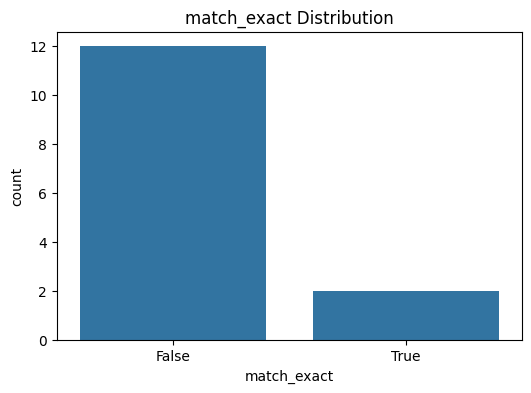

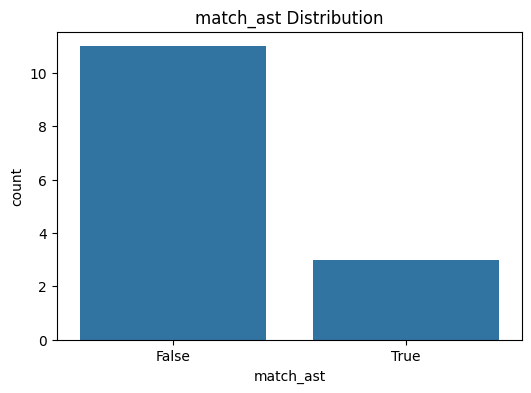

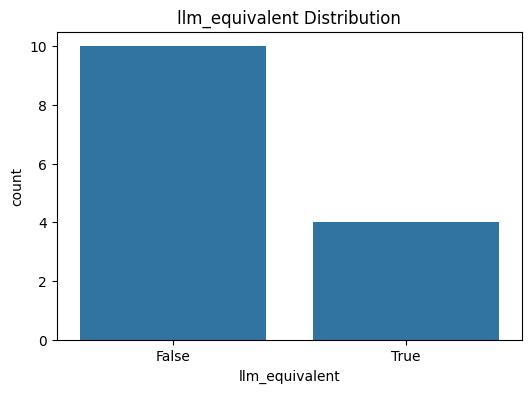

match_exact       0.142857
match_ast         0.214286
llm_equivalent    0.285714
dtype: float64


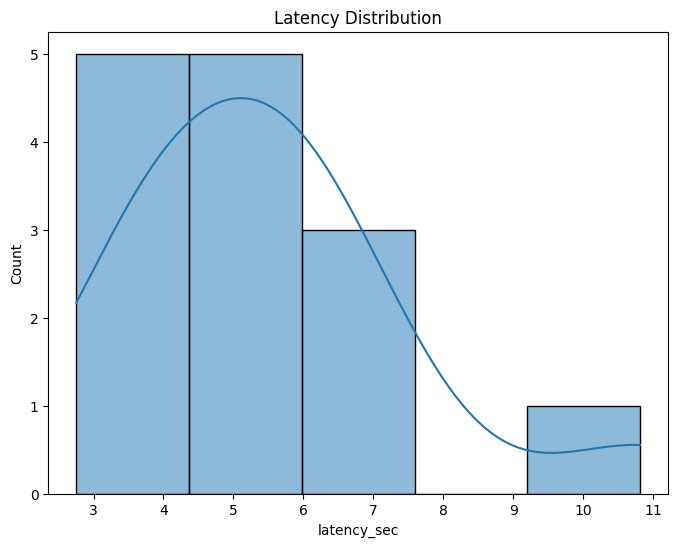

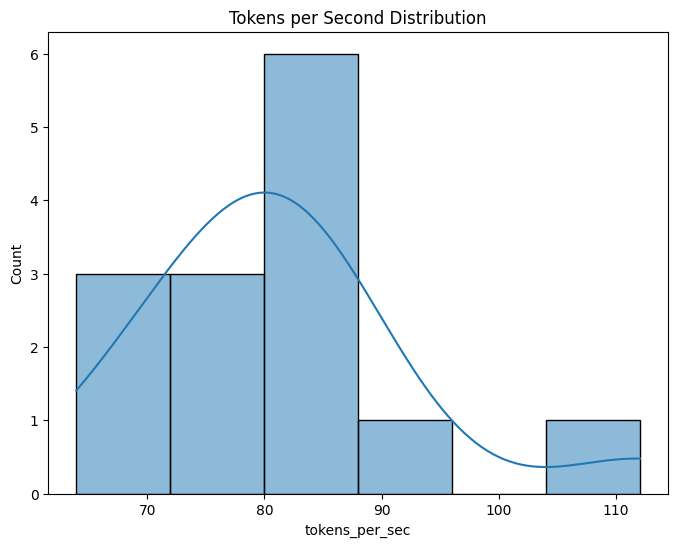

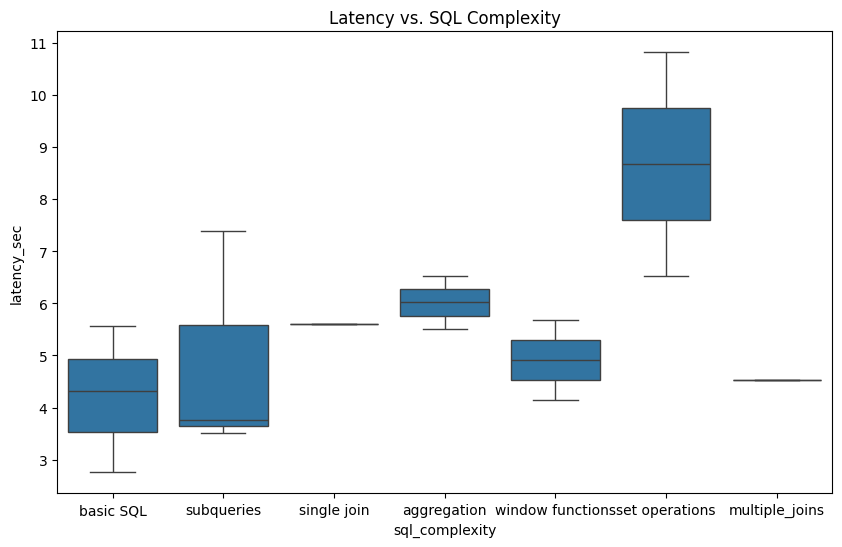

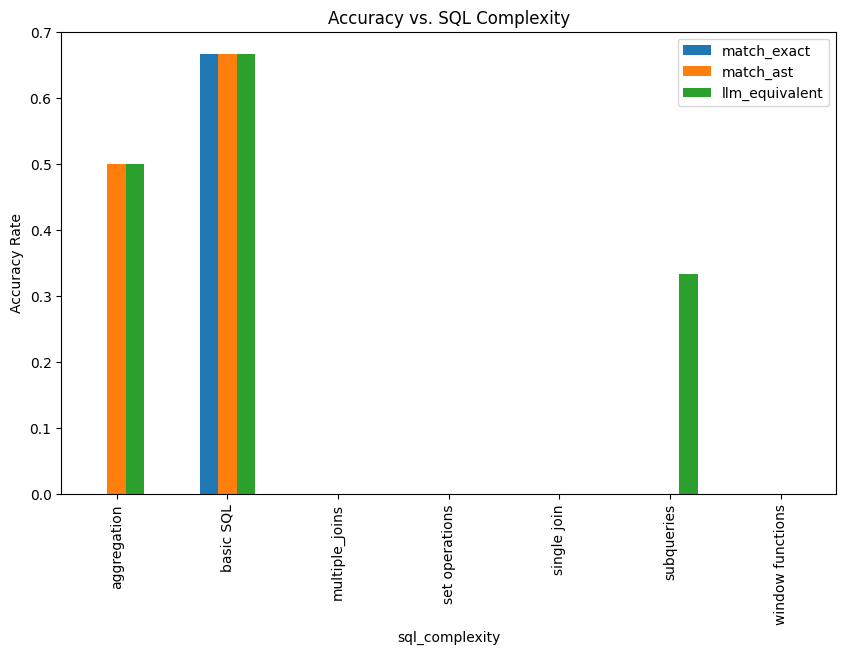

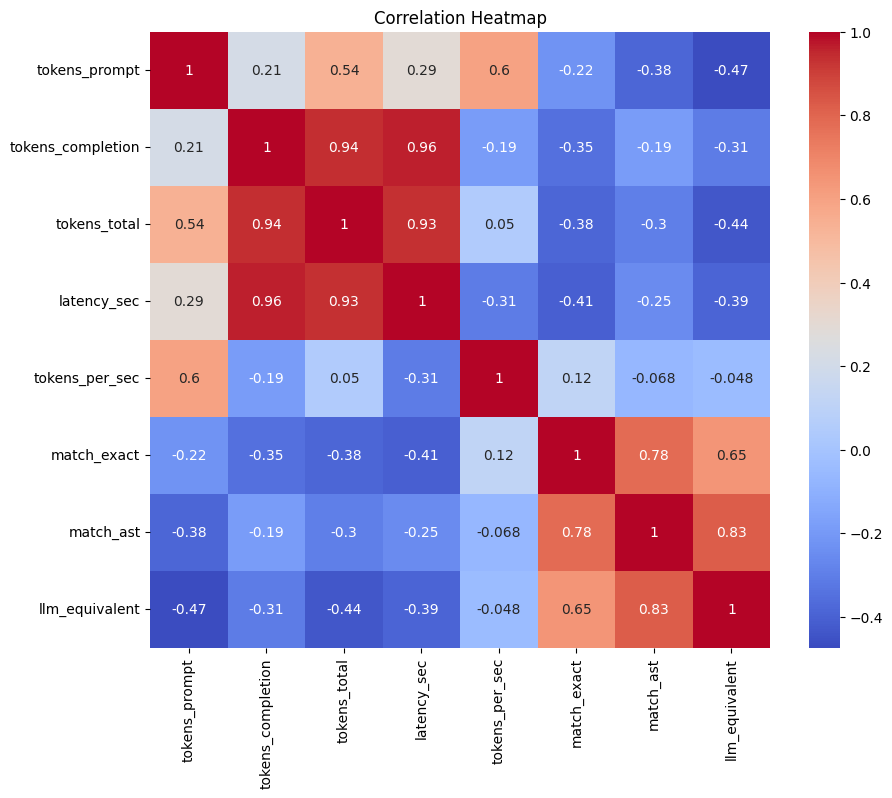

In [28]:
visualize_benchmark_results2(LOG_PATH)